In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os

In [2]:
from tensorflow.keras.layers import Dense, Input, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
mnist=tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test)=mnist.load_data()

In [4]:
# map inputs to (-1, +1) for better training
x_train, x_test = (x_train/255.0) * 2 - 1, (x_test*255.0) * 2 - 1
print(x_train.shape)

(60000, 28, 28)


In [5]:
# Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)
print(x_train.shape)

(60000, 784)


In [6]:
latent_dim = 100

In [7]:
# Build the generator model
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(D, activation='tanh')(x)
    
    model=Model(i, x)
    return model

In [8]:
# Build the discriminator model
def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    model=Model(i, x)
    return model

In [9]:
# Compile both models in preparation for training

# Build and compile the discriminator model
discriminator=build_discriminator(D)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Build and compile the combined model 
generator=build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z=Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

fake_pred=discriminator(img)

# Create the combined model object
combined_model=Model(z, fake_pred)

combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [10]:
# Train the GAN

#config
batch_size=32
epochs=30000
sample_period=200 #every 'sample_period' steps generate and save some data

#Create batch labels to use when calling train_on_batch
ones=np.ones(batch_size)
zeros=np.zeros(batch_size)

# Store the losses
d_losses=[]
g_losses=[]

#Create a folder to store generated images
if not os.path.exists('D:/Downloads/gan_images'):
    os.makedirs('D:/Downloads/gan_images')

In [15]:
# A function to generate a grid of random samples from the generator and save them to a file
def sample_images(epoch):
    rows, cols= 5, 5
    noise=np.random.randn(rows*cols, latent_dim)
    
    # getting 25 predicted images using trained model generator
    imgs=generator.predict(noise)
    
    #Rescale images 0 - 1
    imgs=0.5 * imgs + 0.5
    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i, j].axis('off')
            idx+=1
    fig.savefig("D:/Downloads/gan_images/%d.png" % epoch)
    plt.close()

In [16]:
# Main training loop
for epoch in range(epochs):
    ###########################
    ### TRAIN DISCRIMINATOR ###
    ###########################
    
    #Select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)  #generate 32 images between 0 and N i.e. number of samples
    real_imgs = x_train[idx]
    
    #Generate fake images
    noise=np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)
    
    #Train the generator 
    # both loss and accuracy are returned
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)
    
    ######################
    ## TRAIN GENERATOR ##
    #####################
    
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)
    
    #Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
        
    if epoch % sample_period == 0:
        sample_images(epoch)

epoch: 1/30000, d_loss: 0.34, d_acc: 0.80, g_loss: 0.64
epoch: 101/30000, d_loss: 0.01, d_acc: 1.00, g_loss: 4.92
epoch: 201/30000, d_loss: 0.08, d_acc: 0.97, g_loss: 5.22
epoch: 301/30000, d_loss: 0.69, d_acc: 0.72, g_loss: 1.90
epoch: 401/30000, d_loss: 0.30, d_acc: 0.84, g_loss: 3.46
epoch: 501/30000, d_loss: 0.68, d_acc: 0.45, g_loss: 0.76
epoch: 601/30000, d_loss: 0.66, d_acc: 0.48, g_loss: 0.71
epoch: 701/30000, d_loss: 0.67, d_acc: 0.44, g_loss: 0.70
epoch: 801/30000, d_loss: 0.59, d_acc: 0.75, g_loss: 0.79
epoch: 901/30000, d_loss: 0.65, d_acc: 0.58, g_loss: 0.83
epoch: 1001/30000, d_loss: 0.66, d_acc: 0.55, g_loss: 0.87
epoch: 1101/30000, d_loss: 0.61, d_acc: 0.73, g_loss: 0.80
epoch: 1201/30000, d_loss: 0.56, d_acc: 0.75, g_loss: 0.86
epoch: 1301/30000, d_loss: 0.60, d_acc: 0.73, g_loss: 0.88
epoch: 1401/30000, d_loss: 0.57, d_acc: 0.72, g_loss: 0.93
epoch: 1501/30000, d_loss: 0.52, d_acc: 0.78, g_loss: 1.03
epoch: 1601/30000, d_loss: 0.59, d_acc: 0.66, g_loss: 0.94
epoch: 17

epoch: 13901/30000, d_loss: 0.65, d_acc: 0.66, g_loss: 0.91
epoch: 14001/30000, d_loss: 0.63, d_acc: 0.67, g_loss: 0.97
epoch: 14101/30000, d_loss: 0.58, d_acc: 0.67, g_loss: 1.00
epoch: 14201/30000, d_loss: 0.58, d_acc: 0.73, g_loss: 1.01
epoch: 14301/30000, d_loss: 0.71, d_acc: 0.55, g_loss: 0.95
epoch: 14401/30000, d_loss: 0.66, d_acc: 0.66, g_loss: 0.95
epoch: 14501/30000, d_loss: 0.63, d_acc: 0.64, g_loss: 0.95
epoch: 14601/30000, d_loss: 0.59, d_acc: 0.72, g_loss: 0.94
epoch: 14701/30000, d_loss: 0.71, d_acc: 0.55, g_loss: 0.98
epoch: 14801/30000, d_loss: 0.76, d_acc: 0.45, g_loss: 1.09
epoch: 14901/30000, d_loss: 0.56, d_acc: 0.69, g_loss: 0.91
epoch: 15001/30000, d_loss: 0.63, d_acc: 0.62, g_loss: 1.06
epoch: 15101/30000, d_loss: 0.63, d_acc: 0.72, g_loss: 1.04
epoch: 15201/30000, d_loss: 0.66, d_acc: 0.64, g_loss: 0.98
epoch: 15301/30000, d_loss: 0.64, d_acc: 0.62, g_loss: 1.00
epoch: 15401/30000, d_loss: 0.67, d_acc: 0.67, g_loss: 0.92
epoch: 15501/30000, d_loss: 0.57, d_acc:

epoch: 27601/30000, d_loss: 0.60, d_acc: 0.66, g_loss: 1.06
epoch: 27701/30000, d_loss: 0.63, d_acc: 0.61, g_loss: 1.05
epoch: 27801/30000, d_loss: 0.71, d_acc: 0.58, g_loss: 1.02
epoch: 27901/30000, d_loss: 0.61, d_acc: 0.64, g_loss: 0.92
epoch: 28001/30000, d_loss: 0.66, d_acc: 0.59, g_loss: 0.97
epoch: 28101/30000, d_loss: 0.57, d_acc: 0.67, g_loss: 1.11
epoch: 28201/30000, d_loss: 0.71, d_acc: 0.58, g_loss: 1.07
epoch: 28301/30000, d_loss: 0.60, d_acc: 0.72, g_loss: 1.07
epoch: 28401/30000, d_loss: 0.61, d_acc: 0.62, g_loss: 1.09
epoch: 28501/30000, d_loss: 0.62, d_acc: 0.67, g_loss: 1.03
epoch: 28601/30000, d_loss: 0.63, d_acc: 0.61, g_loss: 1.00
epoch: 28701/30000, d_loss: 0.53, d_acc: 0.75, g_loss: 1.03
epoch: 28801/30000, d_loss: 0.58, d_acc: 0.66, g_loss: 1.08
epoch: 28901/30000, d_loss: 0.63, d_acc: 0.61, g_loss: 1.00
epoch: 29001/30000, d_loss: 0.63, d_acc: 0.72, g_loss: 1.20
epoch: 29101/30000, d_loss: 0.71, d_acc: 0.56, g_loss: 0.93
epoch: 29201/30000, d_loss: 0.65, d_acc:

In [19]:
discriminator.save("my_model_gan_discriminator")

INFO:tensorflow:Assets written to: my_model_gan_discriminator\assets


In [18]:
combined_model.save("my_model_gan_combined")

INFO:tensorflow:Assets written to: my_model_gan_combined\assets


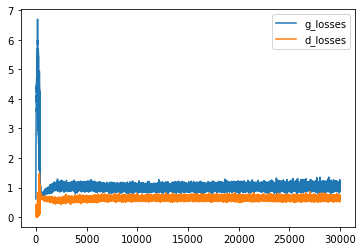

In [20]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

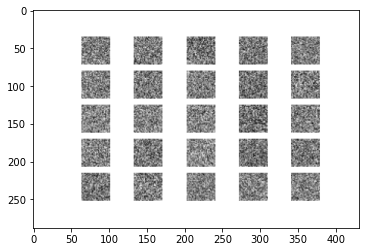

In [21]:
from skimage.io import imread
a = imread("D:/Downloads/gan_images/0.png")
plt.imshow(a)

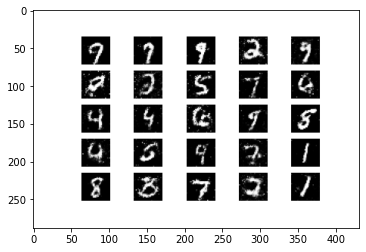

In [22]:
a = imread("D:/Downloads/gan_images/10000.png")
plt.imshow(a)